In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
import symlib
import os


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.constants import G
from astropy import units as u
import symlib  

def density_profile(base_dir, suite_name, snap, n_bins, r_min, r_max):
    """
    Measure the density profile of each host halo in a suite at a given snapshot,
    and save the profile as a pandas DataFrame (columns: halo_idx, r_scaled, rho_scaled).
    """

    # read and compute essential parameters
    n_halos = symlib.n_hosts(suite_name)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    mp = params['mp'] * h  # M_sun
    eps = params['eps'] * h  # kpc
    H0 = params["H0"]  # km/s/Mpc
    Om0 = params["Om0"]

    # compute background density
    H0_si = H0 * (u.km / u.s / u.Mpc)
    G_si = G.to(u.kpc**3 / u.Msun / u.s**2)
    rho_crit = (3 * H0_si**2 / (8 * np.pi * G_si)).to(u.Msun / u.kpc**3).value  # Msun/kpc^3
    rho_m = Om0 * rho_crit

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

        center = host['x'][-1]
        r_vir = host['rvir']  # kpc

        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
            continue

        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir

        bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        counts, _ = np.histogram(radi_scaled, bins=bins)
        shell_volumes = (4/3) * np.pi * ((bins[1:] * r_vir)**3 - (bins[:-1] * r_vir)**3)
        mass_per_bin = counts * mp
        rho = mass_per_bin / shell_volumes  # Msun/kpc^3
        rho_scaled = rho / rho_m

        df = pd.DataFrame({
            "halo_idx": halo_idx,
            "r_scaled": bin_centers,
            "rho_scaled": rho_scaled
        })

        out_path = f"{base_dir}/output/{suite_name}/density_profiles"
        os.makedirs(out_path, exist_ok=True)
        df.to_csv(f"{out_path}/halo_{halo_idx:03d}_profile.csv", index=False)

        print(f"[Saved] Halo {halo_idx:03d} profile saved.")

base_dir = '/Volumes/Atlas/Symphony'
suite_name = 'SymphonyLMC'
density_profile(base_dir, suite_name, snap=235, n_bins=40, r_min=0.001, r_max=1.5)

[Saved] Halo 000 profile saved.
[Saved] Halo 001 profile saved.
[Saved] Halo 002 profile saved.
[Saved] Halo 003 profile saved.
[Saved] Halo 004 profile saved.
[Saved] Halo 005 profile saved.
[Saved] Halo 006 profile saved.
[Saved] Halo 007 profile saved.
[Saved] Halo 008 profile saved.
[Saved] Halo 009 profile saved.
[Saved] Halo 010 profile saved.
[Saved] Halo 011 profile saved.
[Saved] Halo 012 profile saved.
[Saved] Halo 013 profile saved.
[Saved] Halo 014 profile saved.
[Saved] Halo 015 profile saved.
[Saved] Halo 016 profile saved.
[Saved] Halo 017 profile saved.
[Saved] Halo 018 profile saved.
[Saved] Halo 019 profile saved.
[Saved] Halo 020 profile saved.
[Saved] Halo 021 profile saved.
[Saved] Halo 022 profile saved.
[Saved] Halo 023 profile saved.
[Saved] Halo 024 profile saved.
[Saved] Halo 025 profile saved.
[Saved] Halo 026 profile saved.
[Saved] Halo 027 profile saved.
[Saved] Halo 028 profile saved.
[Saved] Halo 029 profile saved.
[Saved] Halo 030 profile saved.
[Saved] 

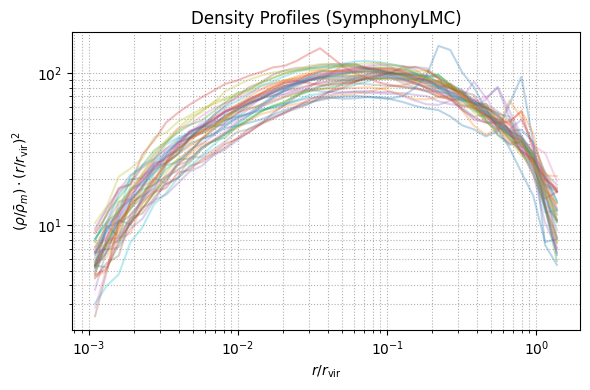

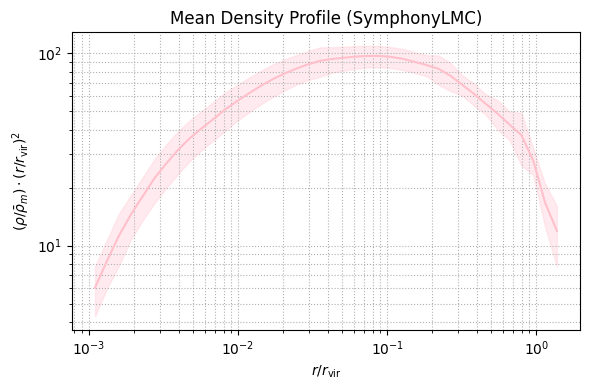

[Done] Plots saved to /Volumes/Atlas/Symphony/output/SymphonyLMC/figures/


In [6]:
from glob import glob

def plot_density(base_dir, suite_name):
    """
    Plot every halo's scaled density profile (rho * r^2 vs r) and the mean profile of the given suite.
    
    It outputs and saves two plots:
    (1) All halos' profiles overplotted with low opacity.
    (2) Mean profile with 68% (±1 sigma) shaded region.
    """

    profile_dir = f"{base_dir}/output/{suite_name}/density_profiles"
    file_list = sorted(glob(f"{profile_dir}/halo_*_profile.csv"))

    if not file_list:
        print("[Error] No profile files found.")
        return

    # Read all profiles
    all_profiles = []
    for file in file_list:
        df = pd.read_csv(file)
        df["rho_r2"] = df["rho_scaled"] * df["r_scaled"]**2
        all_profiles.append(df)

    # Extract common bin centers
    r_scaled = all_profiles[0]["r_scaled"].values
    rho_r2_all = np.array([df["rho_r2"].values for df in all_profiles])

    # -------- Plot 1: All halo profiles --------
    plt.figure(figsize=(6, 4))
    for rho_r2 in rho_r2_all:
        plt.loglog(r_scaled, rho_r2, alpha=0.3)
    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel(r"$(\rho/\bar{\rho}_m) \cdot (r/r_{\mathrm{vir}})^2$")
    plt.grid(True, which="both", ls=":")
    plt.title(f"Density Profiles ({suite_name})")
    plt.tight_layout()
    os.makedirs(f"{base_dir}/output/{suite_name}/figures", exist_ok=True)
    plt.savefig(f"{base_dir}/output/{suite_name}/figures/all_halos_profiles.png", dpi=300)
    plt.show()
    plt.close()

    # -------- Plot 2: Mean + 68% range --------
    mean_rho_r2 = np.mean(rho_r2_all, axis=0)
    std_rho_r2 = np.std(rho_r2_all, axis=0)

    plt.figure(figsize=(6, 4))
    plt.loglog(r_scaled, mean_rho_r2, color="pink", label="Mean Profile")
    plt.fill_between(r_scaled, mean_rho_r2 - std_rho_r2, mean_rho_r2 + std_rho_r2,
                     color="pink", alpha=0.3, label=r"$\pm1\sigma$")
    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel(r"$(\rho/\bar{\rho}_m) \cdot (r/r_{\mathrm{vir}})^2$")
    plt.grid(True, which="both", ls=":")
    plt.title(f"Mean Density Profile ({suite_name})")
    plt.tight_layout()
    plt.savefig(f"{base_dir}/output/{suite_name}/figures/mean_profile.png", dpi=300)
    plt.show()   
    plt.close()

    print(f"[Done] Plots saved to {base_dir}/output/{suite_name}/figures/")

plot_density("/Volumes/Atlas/Symphony", "SymphonyLMC")